# **1. Dataset Preparation**

Using device: cuda:0


Some examples from the dataset:


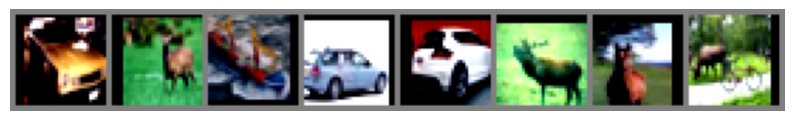

automobile deer  ship  automobile automobile deer  horse deer 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for training data (with augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Define transformations for testing data (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load the CIFAR-10 training and testing datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders for batch processing
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the classes in CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training images to visualize
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
print('Some examples from the dataset:')
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]:5}' for j in range(8)))



# **2. Neural Network Architecture**

In [3]:
class IntermediateBlock(nn.Module):
    """
    Intermediate block as described in the assignment:
    - Multiple independent convolutional layers that receive the same input
    - Weights computed from channel averages via a fully connected layer
    - Weighted combination of convolutional outputs
    """
    def __init__(self, in_channels, out_channels, num_conv_layers=4, kernel_size=3, padding=1):
        super(IntermediateBlock, self).__init__()

        self.num_conv_layers = num_conv_layers

        # Create multiple independent convolutional layers with batch normalization
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(num_conv_layers)
        ])

        # Fully connected layer to compute weights for each conv layer
        self.fc_weights = nn.Sequential(
            nn.Linear(in_channels, num_conv_layers),
            nn.Softmax(dim=1)  # Softmax ensures weights sum to 1
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Calculate the average value of each channel (m vector in the assignment)
        # Shape: [batch_size, in_channels]
        m = F.adaptive_avg_pool2d(x, 1).view(batch_size, -1)

        # Compute weights using the fully connected layer
        # Shape: [batch_size, num_conv_layers]
        weights = self.fc_weights(m)

        # Apply each convolutional layer to the input
        conv_outputs = [conv_layer(x) for conv_layer in self.conv_layers]

        # Weight and combine the outputs
        output = torch.zeros_like(conv_outputs[0])
        for i, conv_output in enumerate(conv_outputs):
            # Expand weights to match conv_output dimensions for broadcasting
            weight = weights[:, i:i+1].unsqueeze(-1).unsqueeze(-1)
            output += conv_output * weight

        return output

class OutputBlock(nn.Module):
    """
    Output block as described in the assignment:
    - Computes channel averages
    - Passes through fully connected layers to produce logits
    """
    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Calculate the average value of each channel (m vector in the assignment)
        # Shape: [batch_size, in_channels]
        m = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)

        # Pass through classifier to get logits
        logits = self.classifier(m)

        return logits

class ImprovedIntermediateBlock(nn.Module):
    """
    Enhanced intermediate block with residual connections, while maintaining
    the required architecture constraints
    """
    def __init__(self, in_channels, out_channels, num_conv_layers=4, kernel_size=3, padding=1):
        super(ImprovedIntermediateBlock, self).__init__()

        self.num_conv_layers = num_conv_layers

        # Create multiple independent convolutional layers with batch normalization
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(num_conv_layers)
        ])

        # Channel attention for each convolutional layer
        self.fc_weights = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(),
            nn.Linear(128, num_conv_layers),
            nn.Softmax(dim=1)
        )

        # Residual connection if input and output dimensions match
        self.use_residual = (in_channels == out_channels)
        if not self.use_residual:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        batch_size = x.size(0)

        # Calculate the average value of each channel
        m = F.adaptive_avg_pool2d(x, 1).view(batch_size, -1)

        # Compute weights using the fully connected layer
        weights = self.fc_weights(m)

        # Apply each convolutional layer to the input
        conv_outputs = [conv_layer(x) for conv_layer in self.conv_layers]

        # Weight and combine the outputs
        output = torch.zeros_like(conv_outputs[0])
        for i, conv_output in enumerate(conv_outputs):
            weight = weights[:, i:i+1].unsqueeze(-1).unsqueeze(-1)
            output += conv_output * weight

        # Apply residual connection if dimensions match
        if self.use_residual:
            output += residual
        elif hasattr(self, 'downsample'):
            output += self.downsample(residual)

        return output

class CIFAR10Model(nn.Module):
    """
    Optimized neural network architecture for CIFAR-10 classification
    - Smaller model size for faster training
    - Still maintains the required architecture principles
    """
    def __init__(self):
        super(CIFAR10Model, self).__init__()

        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Intermediate blocks
        self.block1 = ImprovedIntermediateBlock(in_channels=64, out_channels=128, num_conv_layers=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16

        self.block2 = ImprovedIntermediateBlock(in_channels=128, out_channels=256, num_conv_layers=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16 -> 8x8

        self.block3 = ImprovedIntermediateBlock(in_channels=256, out_channels=512, num_conv_layers=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8 -> 4x4

        # Output block
        self.output_block = OutputBlock(in_channels=512, num_classes=10)

    def forward(self, x):
        # Initial convolution
        x = self.initial_conv(x)

        # Intermediate blocks
        x = self.pool1(self.block1(x))
        x = self.pool2(self.block2(x))
        x = self.pool3(self.block3(x))

        # Output block
        logits = self.output_block(x)

        return logits

# Create the model
model = CIFAR10Model()
model = model.to(device)
print(model)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model):,}")

CIFAR10Model(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block1): ImprovedIntermediateBlock(
    (conv_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (fc_weights): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=3, bias=True)
      (3): Softmax(dim=1)
    )
    (downsample): 

# **3. Training and Testing Functions**

In [4]:
def test(model, testloader, criterion):
    """
    Evaluate model on test data
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100. * correct / total
    print(f'Test Loss: {test_loss/len(testloader):.3f}, Test Acc: {test_acc:.2f}%')
    return test_acc

# **4. Optimized Training Strategy**

In [5]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# One-cycle learning rate scheduler
epochs = 40  # Reduced number of epochs
steps_per_epoch = len(trainloader)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.2  # Reach max_lr at 20% of training
)

# Early stopping parameters
patience = 10
early_stop_counter = 0
best_acc = 0

# Lists to store training statistics
train_losses = []
train_accs = []
test_accs = []
batch_losses = []

print(f"Starting training for {epochs} epochs...")
start_time = time.time()

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler after each batch

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Print statistics every 100 batches
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {running_loss/100:.3f}, '
                  f'Train Acc: {100.*correct/total:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}')
            batch_losses.append(running_loss/100)
            running_loss = 0.0

    # Calculate epoch accuracy
    train_acc = 100. * correct / total
    train_accs.append(train_acc)

    # Testing phase
    test_acc = test(model, testloader, criterion)
    test_accs.append(test_acc)

    # Save checkpoint if it's the best model so far
    if test_acc > best_acc:
        best_acc = test_acc
        print(f'Saving checkpoint... Accuracy: {best_acc:.2f}%')
        torch.save(model.state_dict(), 'cifar10_model_best.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f'No improvement for {early_stop_counter} epochs. Best accuracy: {best_acc:.2f}%')

    # Early stopping
    if early_stop_counter >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break

end_time = time.time()
print(f'Training completed in {(end_time - start_time)/60:.2f} minutes')
print(f'Best accuracy: {best_acc:.2f}%')


Starting training for 40 epochs...

Epoch 1/40
Epoch: 1, Batch: 100, Loss: 1.850, Train Acc: 31.65%, LR: 0.004242
Epoch: 1, Batch: 200, Loss: 1.522, Train Acc: 37.76%, LR: 0.004966
Epoch: 1, Batch: 300, Loss: 1.369, Train Acc: 41.93%, LR: 0.006164
Test Loss: 1.401, Test Acc: 50.05%
Saving checkpoint... Accuracy: 50.05%

Epoch 2/40
Epoch: 2, Batch: 100, Loss: 1.205, Train Acc: 56.51%, LR: 0.009723
Epoch: 2, Batch: 200, Loss: 1.137, Train Acc: 57.90%, LR: 0.012215
Epoch: 2, Batch: 300, Loss: 1.092, Train Acc: 58.99%, LR: 0.015110
Test Loss: 1.253, Test Acc: 60.27%
Saving checkpoint... Accuracy: 60.27%

Epoch 3/40
Epoch: 3, Batch: 100, Loss: 0.971, Train Acc: 66.12%, LR: 0.021644
Epoch: 3, Batch: 200, Loss: 0.951, Train Acc: 66.16%, LR: 0.025526
Epoch: 3, Batch: 300, Loss: 0.912, Train Acc: 66.80%, LR: 0.029675
Test Loss: 1.188, Test Acc: 64.12%
Saving checkpoint... Accuracy: 64.12%

Epoch 4/40
Epoch: 4, Batch: 100, Loss: 0.845, Train Acc: 70.65%, LR: 0.038189
Epoch: 4, Batch: 200, Loss: 

# **5. Final Evaluation and Visualization**


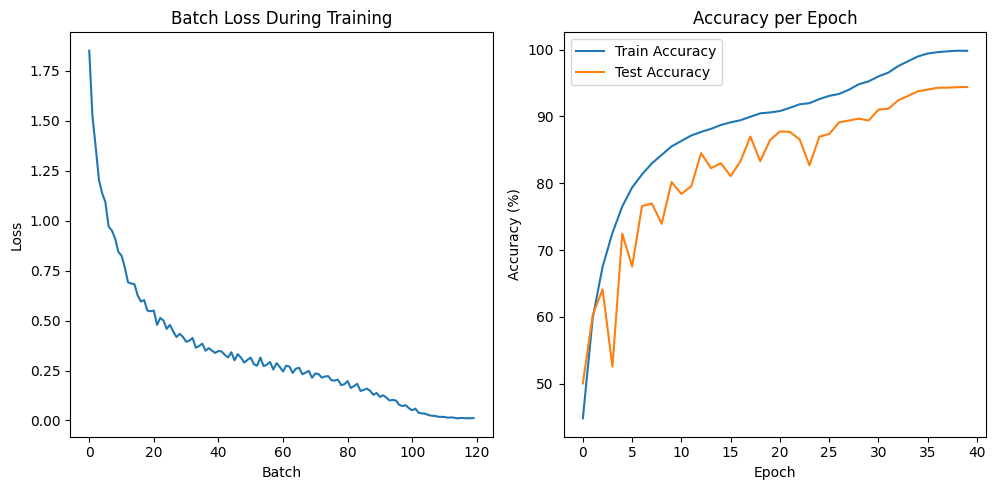


Evaluating the best model:
Final Test Accuracy: 94.39%
Accuracy of airplane: 96.50%
Accuracy of automobile: 97.40%
Accuracy of bird: 92.90%
Accuracy of cat: 86.80%
Accuracy of deer: 95.50%
Accuracy of dog: 91.60%
Accuracy of frog: 95.90%
Accuracy of horse: 94.80%
Accuracy of ship: 96.80%
Accuracy of truck: 95.70%



Sample predictions:
Ground Truth:  cat   ship  ship  airplane frog  frog  automobile frog 
Predicted:     cat   ship  ship  airplane frog  frog  automobile frog 


<Figure size 1200x600 with 0 Axes>

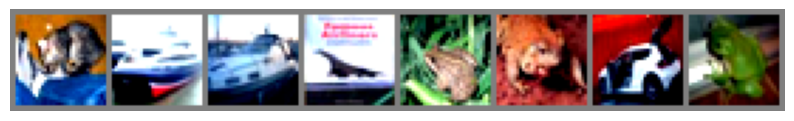


Summary:
1. Dataset: CIFAR-10 with data augmentation
2. Architecture: Custom neural network with intermediate blocks and output block
3. Number of trainable parameters: 14,454,099
4. Best accuracy: 94.39%
5. Training time: 74.40 minutes


In [6]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Plot batch losses
plt.subplot(1, 3, 1)
plt.plot(batch_losses)
plt.title('Batch Loss During Training')
plt.xlabel('Batch')
plt.ylabel('Loss')

# Plot training and testing accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Load the best model and evaluate
def evaluate_best_model():
    # Load the best model
    best_model = CIFAR10Model()
    best_model.load_state_dict(torch.load('cifar10_model_best.pth'))
    best_model = best_model.to(device)
    best_model.eval()

    # Test accuracy
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_model(inputs)

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    final_accuracy = 100. * correct / total
    print(f'Final Test Accuracy: {final_accuracy:.2f}%')

    # Class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_model(inputs)

            _, predicted = outputs.max(1)
            c = predicted.eq(targets).cpu().numpy()

            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i]
                class_total[label] += 1

    # Print class-wise accuracy
    for i in range(10):
        print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    # Visualize some predictions
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images.to(device)

    # Get predictions
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Print results
    print('\nSample predictions:')
    print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5}' for j in range(8)))
    print('Predicted:    ', ' '.join(f'{classes[predicted[j].item()]:5}' for j in range(8)))

    # Show images
    images = images.cpu()
    plt.figure(figsize=(12, 6))
    imshow(torchvision.utils.make_grid(images[:8]))

    return final_accuracy

# Evaluate the best model
print("\nEvaluating the best model:")
final_acc = evaluate_best_model()

# Summary
print("\nSummary:")
print("1. Dataset: CIFAR-10 with data augmentation")
print("2. Architecture: Custom neural network with intermediate blocks and output block")
print(f"3. Number of trainable parameters: {count_parameters(model):,}")
print(f"4. Best accuracy: {best_acc:.2f}%")
print(f"5. Training time: {(end_time - start_time)/60:.2f} minutes")